In [1]:
# How have Airbnb rental prices changed over time (between 2008 and ?)?
# Which is the cheapest booking available per city and most expensive? VISUALIZATION (line chart, try box+whisker)
## Min (Cheapest)
## Mean (Average)
## Max (Most expensive) 
# Are superhost properties more or less expensive than ones that aren’t? and/or what percentage of airbnb properties are managed by superhosts?
# What is the range of rental prices for each neighborhood and metro area (neighborhood group)?

In [1]:
# import modules
import os
import csv
import pandas as pd
import numpy as np
import scipy.stats as st

# import modules for visualization
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
from holoviews import opts

In [2]:
# create an Airbnb dataframe
airbnb_df = pd.read_csv('Resources/air bnb csv with edits.csv')
airbnb_df.head()

,id,name,host_id,host_name,host_since,host_is_superhost,host_identity_verified,instant_bookable,accommodates,amenities,...,bedrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,27-06-2008,f,t,f,6,"[""Elevator"", ""Cable TV"", ""Air conditioning"", ""...",...,2.0,3.0,115,30,730,2,15-05-2016,0.02,1,216
1,2708,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,3008,Chas.,16-09-2008,t,t,t,1,"[""Host greets you"", ""Elevator"", ""Air condition...",...,1.0,1.0,71,30,366,27,6/10/2020,0.35,2,360
2,2732,Zen Life at the Beach,3041,Yoga Priestess,17-09-2008,f,t,f,1,"[""Cooking basics"", ""Host greets you"", ""Smoke a...",...,1.0,1.0,155,1,180,21,27-12-2019,0.18,2,337
3,2864,* Beautiful Master Suite/Jacuzzi Tub/*,3207,Bernadine,25-09-2008,f,t,t,2,"[""Host greets you"", ""Air conditioning"", ""Carbo...",...,1.0,1.0,50,30,730,0,NaN,NaN,1,0
4,5728,Tiny Home in Artistic Oasis near Venice and LAX,9171,Sanni,5/3/2009,t,t,f,2,"[""Lock on bedroom door"", ""Fire extinguisher"", ...",...,1.0,1.0,60,30,1125,310,29-04-2020,2.25,5,337


In [3]:
states = airbnb_df['State'].unique()
states

array(['California', 'Illinois', 'Florida', 'Hawaii', 'Nevada',
       'New York ', 'Tennessee', 'DC', 'Washington'], dtype=object)

In [4]:
# change state names to abbreviations for easy visualization
# create a dictionary mapping state names to abbreviations
state_abbreviations = {
    'California': 'CA',
    'Illinois': 'IL',
    'Florida': 'FL',
    'Hawaii':'HI',
    'Nevada':'NV',
    'New York':'NY',
    'Tennessee':'TN',
    'DC':'DC',
    'Washington':'WA'
}

# Example list of state names
state_names = ['California', 'Illinois', 'Florida', 'Hawaii', 'Nevada','New York', 'Tennessee', 'DC', 'Washington']

# Convert state names to abbreviations
states = [state_abbreviations[state] for state in state_names]

# Apply the mapping to the 'State' column
airbnb_df['State Abbreviation'] = airbnb_df['State'].map(state_abbreviations)

In [5]:
# get column names list
airbnb_df.columns

Index(['id', 'name', 'host_id', 'host_name', 'host_since', 'host_is_superhost',
       'host_identity_verified', 'instant_bookable', 'accommodates',
       'amenities', 'State', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'property_type', 'room_type', 'bathrooms',
       'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'State Abbreviation'],
      dtype='object')

In [6]:
# remove unnecessary columns
clean_airbnb_df = airbnb_df.drop(columns=['host_identity_verified', 'instant_bookable', 'accommodates',
       'amenities', 'latitude', 'longitude','room_type', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month','availability_365'])
clean_airbnb_df.head(5)

,id,name,host_id,host_name,host_since,host_is_superhost,State,neighbourhood_group,neighbourhood,property_type,price,calculated_host_listings_count,State Abbreviation
0,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,27-06-2008,f,California,Los Angeles,Culver City,Entire condominium,115,1,CA
1,2708,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,3008,Chas.,16-09-2008,t,California,Los Angeles,Hollywood,Private room in apartment,71,2,CA
2,2732,Zen Life at the Beach,3041,Yoga Priestess,17-09-2008,f,California,Los Angeles,Santa Monica,Private room in apartment,155,2,CA
3,2864,* Beautiful Master Suite/Jacuzzi Tub/*,3207,Bernadine,25-09-2008,f,California,Los Angeles,Bellflower,Entire apartment,50,1,CA
4,5728,Tiny Home in Artistic Oasis near Venice and LAX,9171,Sanni,5/3/2009,t,California,Los Angeles,Del Rey,Private room in tiny house,60,5,CA


In [7]:
# cities that are represented in the data
cities = clean_airbnb_df["neighbourhood_group"].unique()
cities

array(['Los Angeles', 'San Diego County', 'San Francisco', 'San Mateo',
       'Saint Clara County', ' Santa Cruz', 'Chicago', 'Broward County',
       'Hawaii', 'Kauai', 'Maui', 'Honolulu', 'Clark County', 'Manhattan',
       'Brooklyn', 'Queens', 'Staten Island', 'Bronx', 'Nashville',
       'Washington D.C', 'Seattle'], dtype=object)

In [8]:
cities_count = clean_airbnb_df["neighbourhood_group"].nunique()
cities_count

21

In [23]:
# reformat dates
# Ensure 'host_since' is of string type
clean_airbnb_df['host_since'] = clean_airbnb_df['host_since'].astype(str)

# Now convert to datetime, allowing for multiple formats
# replace '-' with '/' in the 'host_since' column to standardize the format
clean_airbnb_df['host_since'] = clean_airbnb_df['host_since'].str.replace('-', '/')
clean_airbnb_df['host_since'] = pd.to_datetime(clean_airbnb_df['host_since'], errors='coerce')
clean_airbnb_df.head(15)

,id,name,host_id,host_name,host_since,host_is_superhost,State,neighbourhood_group,neighbourhood,property_type,price,calculated_host_listings_count,State Abbreviation
0,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,2008-06-27,f,California,Los Angeles,Culver City,Entire condominium,115,1,CA
1,2708,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,3008,Chas.,2008-09-16,t,California,Los Angeles,Hollywood,Private room in apartment,71,2,CA
2,2732,Zen Life at the Beach,3041,Yoga Priestess,2008-09-17,f,California,Los Angeles,Santa Monica,Private room in apartment,155,2,CA
3,2864,* Beautiful Master Suite/Jacuzzi Tub/*,3207,Bernadine,2008-09-25,f,California,Los Angeles,Bellflower,Entire apartment,50,1,CA
4,5728,Tiny Home in Artistic Oasis near Venice and LAX,9171,Sanni,2009-03-05,t,California,Los Angeles,Del Rey,Private room in tiny house,60,5,CA
5,5729,Zen Room with Floating Bed near Venice and LAX,9171,Sanni,2009-03-05,t,California,Los Angeles,Del Rey,Private room in guesthouse,70,5,CA
6,5843,Artist Oasis near Venice Beach w/ Beautiful Ga...,9171,Sanni,2009-03-05,t,California,Los Angeles,Del Rey,Entire house,125,5,CA
7,6931,Beau Furn Rm Dres Rm/Wlk-In Clst Terr. Runyon Vw,3008,Chas.,2008-09-16,t,California,Los Angeles,Hollywood,Private room in apartment,73,2,CA
8,7874,Sunny and Private 2nd story Queen Bedroom,21700,Henry,2009-06-15,f,California,Los Angeles,Bellflower,Private room in house,55,3,CA
9,7992,"Quiet,Walkable Area/Sanitized/CozySpot",22363,Tom,2009-06-19,t,California,Los Angeles,Atwater Village,Entire guesthouse,89,2,CA


In [9]:
# summary statistics for Airbnb prices
clean_airbnb_df["price"].describe()

count    158249.000000
mean        204.370720
std         500.228507
min           0.000000
25%          75.000000
50%         120.000000
75%         200.000000
max       25000.000000
Name: price, dtype: float64

In [66]:
# average prices for each city/county (some are counties, some are cities)
# median chosen because there seemed to be some big outliers
median_prices = clean_airbnb_df.groupby("neighbourhood_group")['price'].median().round(2).sort_values(ascending=True)
median_prices

neighbourhood_group
Bronx                  65.0
Queens                 70.0
Staten Island          76.5
Brooklyn               90.0
Chicago                97.0
Saint Clara County     99.0
Washington D.C        105.0
Seattle               106.0
Los Angeles           110.0
San Mateo             120.0
Broward County        121.0
Manhattan             124.0
Clark County          129.0
San Francisco         133.0
San Diego County      140.0
Honolulu              141.0
Nashville             150.0
Hawaii                150.0
 Santa Cruz           225.0
Maui                  226.0
Kauai                 236.0
Name: price, dtype: float64

In [68]:
# max values for each metro area
max_prices = clean_airbnb_df.groupby("neighbourhood_group")['price'].max().round(2).sort_values(ascending=True)
max_prices

neighbourhood_group
Staten Island          1200
Bronx                  2000
 Santa Cruz            3250
Seattle                3503
Kauai                  4200
Nashville              5000
Brooklyn               6500
San Mateo             10000
Saint Clara County    10000
Queens                10000
Manhattan             10000
Clark County          10000
Chicago               10000
Broward County        10000
Washington D.C        10000
Maui                  24999
Honolulu              24999
Hawaii                24999
San Diego County      24999
Los Angeles           24999
San Francisco         25000
Name: price, dtype: int64

In [70]:
# min values for each metro area
min_prices = clean_airbnb_df.groupby("neighbourhood_group")['price'].min().round(2).sort_values(ascending=True)
min_prices

neighbourhood_group
Manhattan              0
San Diego County       0
Saint Clara County     0
Los Angeles            0
Honolulu               0
Washington D.C         0
Chicago                0
Brooklyn               0
Bronx                  0
Nashville             10
Queens                10
San Francisco         10
Clark County          10
Broward County        12
Hawaii                14
Seattle               16
San Mateo             19
Maui                  20
Staten Island         22
 Santa Cruz           30
Kauai                 44
Name: price, dtype: int64

In [72]:
# Create a data frame showing mean, min, max for each city
# Group by 'neighbourhood_group' and calculate mean, min, and max prices
metro_price_stats_df = pd.DataFrame(clean_airbnb_df.groupby(['neighbourhood_group', 'State Abbreviation'])['price'].agg(['median', 'min', 'max']).round(2))

# Reset the index to turn the grouped index into a column
metro_price_stats_df = metro_price_stats_df.reset_index()

# Rename the columns for clarity
metro_price_stats_df.columns = ['Metro Area', 'State Abbreviation', 'Median Price', 'Min Price', 'Max Price']

# First, sort the DataFrame by the 'State Abbreviation' column
metro_price_stats_df = metro_price_stats_df.sort_values(by='State Abbreviation', ascending=True)

# Modify the 'Metro Area' column to include the state name after the city name
metro_price_stats_df['Metro Area'] = metro_price_stats_df['Metro Area'] + ', ' + metro_price_stats_df['State Abbreviation']

# Drop the 'State' column
metro_price_stats_df = metro_price_stats_df.drop(columns=['State Abbreviation'])

# Sort values by mean
# metro_price_stats_df = metro_price_stats.sort_values(by='Median Price', ascending=True)

# Display the resulting DataFrame
metro_price_stats_df

,Metro Area,Median Price,Min Price,Max Price
0,"Santa Cruz, CA",225.0,30,3250
7,"Los Angeles, CA",110.0,0,24999
10,"Saint Clara County, CA",99.0,0,10000
11,"San Diego County, CA",140.0,0,24999
12,"San Francisco, CA",133.0,10,25000
13,"San Mateo, CA",120.0,19,10000
15,"Washington D.C, DC",105.0,0,10000
1,"Broward County, FL",121.0,12,10000
4,"Hawaii, HI",150.0,14,24999
5,"Honolulu, HI",141.0,0,24999


Median Prices per Metro Area

In [75]:
# Take out 0 values from min price?
# worth sorting by median price?
# in original data frame, change state to abbreviation (formula for that?)

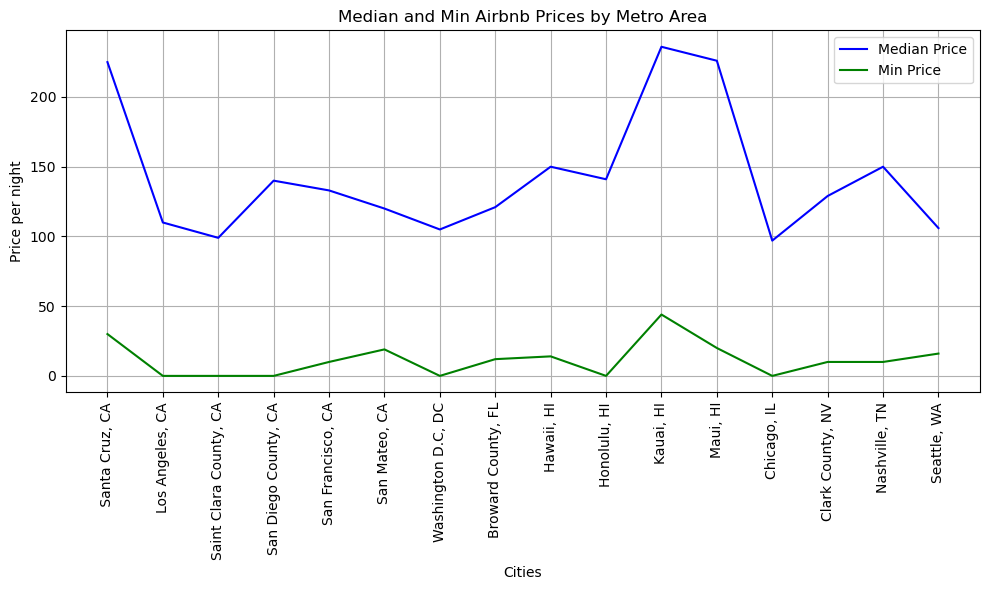

In [77]:
# create line graphs showing mean, min, and max prices for each city

# Extract the cities and corresponding prices
cities = metro_price_stats_df['Metro Area']
median_prices = metro_price_stats_df['Median Price']
min_prices = metro_price_stats_df['Min Price']
# max_prices = metro_price_stats_df['Max Price']

# Create line plots
plt.figure(figsize=(10, 6))
plt.plot(cities, median_prices, color="blue", label="Median Price")
plt.plot(cities, min_prices, color="green", label="Min Price")
# plt.plot(cities, max_prices, color="red", label="Max Price")

# Add titles and labels
plt.title("Median and Min Airbnb Prices by Metro Area")
plt.xlabel("Cities")
plt.ylabel("Price per night")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.grid()

# Save plot as image file
plt.savefig("output_data/Fig1a.png")

# Show the plot
plt.show()

<Figure size 1200x600 with 0 Axes>

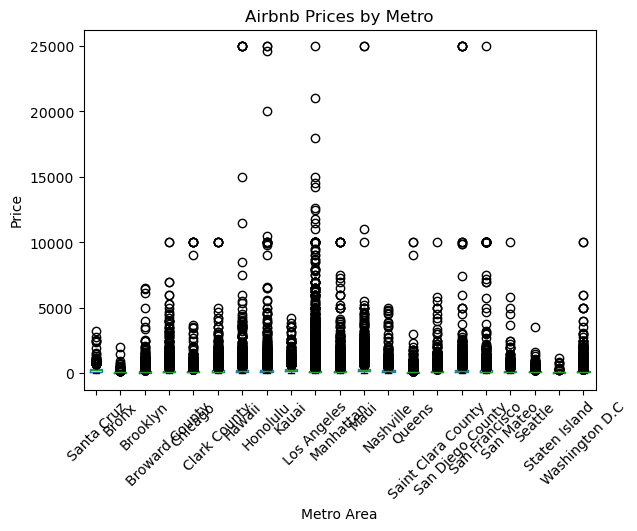

In [42]:

plt.figure(figsize=(12, 6))
airbnb_df.boxplot(column='price', by='neighbourhood_group', grid=False)

plt.title('Airbnb Prices by Metro')
plt.suptitle('')  # Suppress the default title to make it cleaner
plt.xlabel('Metro Area')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x labels for better readability

# Save plot as image file
plt.savefig("output_data/Fig1b.png")

plt.show()

In [145]:
# For max values, identify the host_id/name - is it a hotel?

In [27]:
# Change over time (2008 to present)
clean_airbnb_df['host_since']

0        2008-06-27
1        2008-09-16
2        2008-09-17
3        2008-09-25
4        2009-03-05
            ...    
158244   2016-04-05
158245   2016-04-05
158246   2016-04-05
158247   2016-04-05
158248   2016-05-20
Name: host_since, Length: 158249, dtype: datetime64[ns]

In [147]:
# Are superhost properties more or less expensive than ones that aren’t? and/or what percentage of airbnb properties are managed by superhosts?

In [148]:
# What is the range of rental prices for each neighborhood and metro area (neighborhood group)?